#STB Q1

NoteBook in Colab - <https://colab.research.google.com/drive/144MsDG8cz4J1AjZrCCrUMkkRTdIA3W5Z?usp=sharing>

## Question 1

Some of the respondents have been tagged as belonging to group 1 – 6. However, due to a data calculation issue, some of the respondents have had their groups (pov6) missing.

Build a model that will classify these respondents back into one of the 6 groups.

- Please explain the choice of metric / evaluation criterion used
- What are the assumptions you made when building this model?
- What were the approaches you considered? Please explain the reason for the technique / approach used as well as the pros and cons.
- Please explain under what conditions will the model you choose be not appropriate
- How confident are you of the model’s robustness and how would you explain the model’s performance?
- Why is your model performing well / not well?
- Was any feature engineering required? If yes, what were they. If no, why?

Please include your supporting scripts/output from R or an alternative tool of your choice. 


## Answers

### 1a. Please explain the choice of metric / evaluation criterion used
- Confusion Matrix (Main). To check each class accuracy. 
- K-Fold validation. To check model overall accuracy.

### 1b. What are the assumptions you made when building this model?
- `spenddata.csv` for model training
- `testdata.csv` for prediction
- Categorical value encoding already handled.

### 1c. What were the approaches you considered? Please explain the reason for the technique / approach used as well as the pros and cons.

- EDA.
- Data Cleaning. (Skip here. Selecting XGBoost, hope it handle missing value well)
- Start with general best algorithm. - XGBoost
- Feature Extraction. Use Correlation Matrix.
- Reduce Features to speed up traninig time. Use Feature Importance checking in Model. 
- Tunning after model - Time + Accuracy. Did not do it here due to time constraint. 
- Try new algorithm/framework. - Deep Learning (If time and hardware available)
- Cons: The process is slow and Manual. 
- Pros: Result is more explainable compare to use deep learning.

### 1d. Please explain under what conditions will the model you choose be not appropriate

- Predicted value is has sequence dependencies, value is continuos, maybe regressor should be used instead.
- `spenddata.csv` and `testdata.csv` POV6 has different meaning. 

### 1e. How confident are you of the model’s robustness and how would you explain the model’s performance?

- Consider low confidence. If majority of the data is belong to Group 1, this is a good model. Overall K Fold validation result 93% ~ 95%.  
- Class Level Accruacy based on Confusion Matrix Calc.
  - group: 1 correct 4623  total 4708 accuracy 98.19%
  - group: 2 correct 983  total 1064 accuracy 92.39%
  - group: 3 correct 84  total 94 accuracy 89.36%
  - group: 4 correct 36  total 63 accuracy 57.14%
  - group: 5 correct 38  total 46 accuracy 82.61%
  - group: 6 correct 66  total 91 accuracy 72.53%
- Bad in predicting POV6 - Group 4 and 6
- The confusion matrix show the model is only good in predicting Group 1 data.

### 1f. Why is your model performing well / not well?

- Not well. Due to the imbalance training data. 
- ~77% POV6 value is 1 in the training data, hence the model is very good in predicting POV6 Group 1.

### 1g. Was any feature engineering required? If yes, what were they. If no, why?

- Did not do any feature engineering due to lack of understanding of the feature (column name).


### Upload Data To Google Colab

In [ ]:
!ls

sample_data		   spark-2.4.7-bin-hadoop2.7.tgz  testdata.csv
spark-2.4.7-bin-hadoop2.7  spenddata.csv		  testdata_result.csv


In [ ]:
from google.colab import files
# files.upload() # enable the code to upload the data files

In [ ]:
!ls testdata.csv # Check if upload success
!ls spenddata.csv # Check if upload success

testdata.csv
spenddata.csv


### Load Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier, plot_importance
import seaborn as sns
import matplotlib.pyplot as plt
import time


In [ ]:
df_spend = pd.read_csv('spenddata.csv')
df_spend.head()

,Unnamed: 0,month,var8,var6,a.1,a.2,a.3,a.4,var5,b.5,b.6,b.7,b.8,b.9,b.10,b.11,b.12,b.13,b.14,b.15,b.16,b.17,b.18,b.19,b.20,b.21,b.22,pov6,b.23,b.24,b.25,b.26,b.27,b.28,c.29,c.30,var7,c.31,c.32,c.33,...,c.246,c.247,c.248,c.249,c.250,c.251,c.252,c.253,c.254,c.255,c.256,c.257,c.258,c.259,c.260,c.261,c.262,c.263,c.264,c.265,c.266,c.267,c.268,c.269,c.270,c.271,c.272,c.273,c.274,c.275,c.276,c.277,c.278,c.279,c.280,c.281,c.282,c.283,f.284,t.158
0,1,1,2.0,NaN,1,5,1,57,34,1,NaN,1,1.0,2,NaN,NaN,2,NaN,NaN,6,6,6.0,6.0,7,0.0,0.0,14,1,0,0,0,0,0,0,1,1,1,1.0,1,1,...,1,0,0,1,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,5.0,NaN
1,2,1,2.0,NaN,1,4,1,57,34,2,3.0,1,1.0,2,NaN,NaN,2,NaN,NaN,50,50,50.0,50.0,12,0.0,0.0,31,1,14,0,0,0,0,0,2,2,2,NaN,2,0,...,1,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,NaN,NaN
2,3,1,2.0,NaN,1,5,1,57,42,2,1.0,1,1.0,1,93.0,1.0,1,93.0,60.0,6,6,6.0,6.0,7,0.0,0.0,45,1,31,0,0,0,0,0,2,2,3,NaN,2,0,...,0,0,0,1,500.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,NaN
3,4,1,2.0,NaN,1,6,1,57,34,2,4.0,1,1.0,2,NaN,NaN,2,NaN,NaN,7,7,7.0,7.0,8,0.0,0.0,14,1,31,0,0,0,0,0,2,2,2,NaN,2,0,...,1,0,0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,5.0,NaN
4,5,1,2.0,NaN,1,8,1,22,1,1,NaN,1,2.0,1,102.0,0.0,1,93.0,3.0,2,2,2.0,2.0,3,0.0,0.0,32,2,0,0,0,0,0,0,2,2,2,NaN,2,1,...,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,NaN


### EDA 


In [ ]:
# Check POV6 Category Values
df_spend.pov6.unique()

array([1, 2, 4, 6, 3, 5])

In [ ]:
print('Value 1 occurrence {:.2f}%'.format(df_spend.pov6[df_spend.pov6 == 1].count()/df_spend.pov6.count() * 100))
print('Value 2 occurrence {:.2f}%'.format(df_spend.pov6[df_spend.pov6 == 2].count()/df_spend.pov6.count() * 100))
print('Value 3 occurrence {:.2f}%'.format(df_spend.pov6[df_spend.pov6 == 3].count()/df_spend.pov6.count() * 100))
print('Value 4 occurrence {:.2f}%'.format(df_spend.pov6[df_spend.pov6 == 4].count()/df_spend.pov6.count() * 100))
print('Value 5 occurrence {:.2f}%'.format(df_spend.pov6[df_spend.pov6 == 5].count()/df_spend.pov6.count() * 100))
print('Value 6 occurrence {:.2f}%'.format(df_spend.pov6[df_spend.pov6 == 6].count()/df_spend.pov6.count() * 100))

Value 1 occurrence 77.25%
Value 2 occurrence 17.66%
Value 3 occurrence 1.82%
Value 4 occurrence 1.00%
Value 5 occurrence 0.72%
Value 6 occurrence 1.55%


In [ ]:
# Correlation Matrix
corrmat = df_spend.corr()

#### Find Correlation Features - First Round 


In [ ]:
# correlation map to select best features

best_acc = 0
best_feature = 0

# for i in range(3, 300):
for i in (63, 66, 216, 282, 300):
  k = i # Number of variables for heatmap
  cols = corrmat.nlargest(k, 'pov6')['pov6'].index
  # print(cols) # Largest related to SalePrice

  df_train = df_spend[cols]
  X = df_train.iloc[:,1:]
  y = df_train.iloc[:,0]

  seed = 7
  test_size = 0.33
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

  model = XGBClassifier()
  start = time.process_time()
  model.fit(X_train, y_train)
  
  # make predictions for test data
  y_pred = model.predict(X_test)
  predictions = [round(value) for value in y_pred]
  
  # evaluate predictions
  accuracy = accuracy_score(y_test, predictions)
  
  if (best_acc < (accuracy * 100.0)):
    print(k, ("corr feature(s) used. Accuracy: {:.2f}%. Time Taken: {:.2f}".format((accuracy * 100.0), (time.process_time() - start))))
    best_acc = (accuracy * 100.0)
    best_feature = k
  
print("Best Corr Feature to used:", best_feature)

## Result 

# 301
# 2 corr feature(s) used. Accuracy: 87.55%
# 8 corr feature(s) used. Accuracy: 93.75%
# 9 corr feature(s) used. Accuracy: 94.21%
# 10 corr feature(s) used. Accuracy: 94.23%
# 11 corr feature(s) used. Accuracy: 94.63%
# 12 corr feature(s) used. Accuracy: 94.68%
# 13 corr feature(s) used. Accuracy: 94.71%
# 19 corr feature(s) used. Accuracy: 94.72%
# 21 corr feature(s) used. Accuracy: 94.76%
# 22 corr feature(s) used. Accuracy: 94.82%
# 37 corr feature(s) used. Accuracy: 94.94%
# 43 corr feature(s) used. Accuracy: 94.96%
# 47 corr feature(s) used. Accuracy: 95.80%
# 52 corr feature(s) used. Accuracy: 95.85%
# 55 corr feature(s) used. Accuracy: 95.94%
# 63 corr feature(s) used. Accuracy: 96.08%
# 66 corr feature(s) used. Accuracy: 96.11%
# 216 corr feature(s) used. Accuracy: 96.13%
# 242 corr feature(s) used. Accuracy: 96.29%
# 258 corr feature(s) used. Accuracy: 96.32%
# 267 corr feature(s) used. Accuracy: 96.39%
# 268 corr feature(s) used. Accuracy: 96.42%
# 276 corr feature(s) used. Accuracy: 96.46%
# 277 corr feature(s) used. Accuracy: 96.51%
# 279 corr feature(s) used. Accuracy: 96.52%
# 282 corr feature(s) used. Accuracy: 96.55%
# Best Corr Feature to used: 282

63 corr feature(s) used. Accuracy: 96.08%. Time Taken: 9.33
66 corr feature(s) used. Accuracy: 96.11%. Time Taken: 9.40
216 corr feature(s) used. Accuracy: 96.13%. Time Taken: 30.52
282 corr feature(s) used. Accuracy: 96.55%. Time Taken: 41.05
Best Corr Feature to used: 282


> Conclusion: To use 66 best features based on the Correlation Map that able to achieve 96.11%. The next improvement is 216 features to achieve ~ 96% accuracy which taking ~3x time relatively. 


#### Feature Extraction


Index(['pov6', 'e.96', 'e.97', 'e.95', 'e.100', 'e.99', 'e.98', 'b.22'], dtype='object')


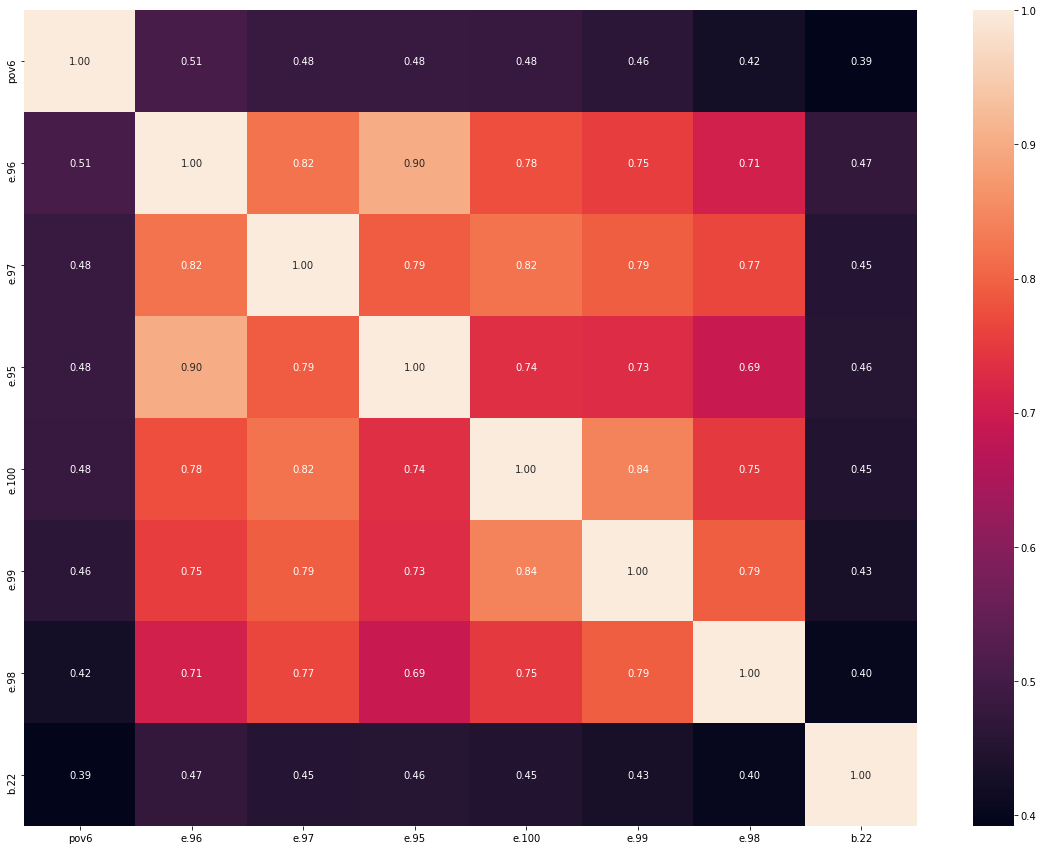

In [ ]:
k = 8 # Number of variables for heatmap

cols = corrmat.nlargest(k, 'pov6')['pov6'].index
print(cols) # Largest related to SalePrice
df_spend[cols].head()

cm = np.corrcoef(df_spend[cols].values.T)
plt.subplots(figsize=(20, 15))
sns.heatmap(
  cm, 
  annot=True, 
  yticklabels=cols.values, 
  xticklabels=cols.values, 
  annot_kws={'size': 10}, #Text Size
  fmt='.2f', # Decimal Point
)
plt.show()

In [ ]:
k = 66 #@param ["Best Number of features"] {allow-input: true}

cols = corrmat.nlargest(k, 'pov6')['pov6'].index
print(cols) # Largest related to SalePrice
df_spend[cols].head()

Index(['pov6', 'e.96', 'e.97', 'e.95', 'e.100', 'e.99', 'e.98', 'b.22',
       'b.192', 'c.217', 'var7', 'c.221', 'f.108', 'f.121', 'c.255', 'b.5',
       'b.193', 'c.69', 'c.159', 't7.173', 'c.218', 'c.165', 't7.178', 'c.259',
       'b.12', 'c.30', 'c.76', 'c.75', 'f.122', 'f.123', 'f.110', 'c.220',
       'c.29', 'f.118', 'f.119', 't7.182', 'f.106', 'c.73', 'c.32', 'f.105',
       'c.163', 'c.203', 'c.256', 't7.176', 'f.109', 'c.70', 'c.189', 'c.71',
       'c.257', 'c.161', 't7.175', 'var0', 'b.9', 'c.205', 'c.66', 'c.65',
       'c.198', 'c.204', 'a.186', 'b.7', 'a.2', 'var3', 'b.195', 't7.180',
       'c.167', 'c.160'],
      dtype='object')


,pov6,e.96,e.97,e.95,e.100,e.99,e.98,b.22,b.192,c.217,var7,c.221,f.108,f.121,c.255,b.5,b.193,c.69,c.159,t7.173,c.218,c.165,t7.178,c.259,b.12,c.30,c.76,c.75,f.122,f.123,f.110,c.220,c.29,f.118,f.119,t7.182,f.106,c.73,c.32,f.105,c.163,c.203,c.256,t7.176,f.109,c.70,c.189,c.71,c.257,c.161,t7.175,var0,b.9,c.205,c.66,c.65,c.198,c.204,a.186,b.7,a.2,var3,b.195,t7.180,c.167,c.160
0,1,3,2,2,2,2,2,14,0,NaN,1,NaN,NaN,NaN,0,1,0,0.0,2,2,NaN,1,1,0,2,1,0.0,0.0,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,0.0,1,NaN,2,0,0,2,NaN,0,1.0,0.0,0,2,2,1,2,0,0.0,0.0,0,0,26.70,1,5,6004575.00,0.0,2,2,2
1,1,2,2,2,2,3,3,31,1,NaN,2,NaN,NaN,NaN,0,2,0,0.0,2,2,NaN,2,2,0,2,2,0.0,0.0,NaN,NaN,NaN,NaN,2,NaN,NaN,2,NaN,0.0,2,NaN,2,0,0,2,NaN,0,7.0,0.0,0,2,2,14,2,0,0.0,0.0,0,0,26.70,1,4,6004575.00,0.0,2,2,2
2,1,4,4,4,4,4,4,45,1,NaN,3,NaN,NaN,NaN,0,2,0,0.0,1,1,NaN,2,2,0,1,2,0.0,0.0,NaN,NaN,NaN,NaN,2,NaN,NaN,1,8.0,0.0,2,13.0,2,0,0,2,NaN,0,7.0,0.0,0,2,2,14,1,0,0.0,0.0,0,0,74.75,1,5,1335537.35,0.0,2,2,2
3,1,2,1,2,2,2,3,14,0,NaN,2,NaN,NaN,NaN,0,2,0,0.0,1,1,NaN,1,1,0,2,2,30.0,0.0,NaN,NaN,NaN,NaN,2,NaN,NaN,1,NaN,0.0,2,NaN,1,0,0,1,NaN,0,7.0,0.0,0,1,1,14,2,0,0.0,0.0,0,0,26.70,1,6,6004575.00,0.0,2,2,2
4,2,2,1,2,1,1,1,32,1,NaN,2,NaN,NaN,NaN,0,1,0,0.0,1,1,NaN,2,2,0,1,2,0.0,0.0,NaN,NaN,NaN,NaN,2,NaN,NaN,1,NaN,0.0,2,NaN,2,0,0,2,NaN,0,1.0,0.0,0,2,2,3,1,0,0.0,0.0,0,0,70.75,1,8,2284165.39,0.0,2,2,2


### Model Training

[0.05661154 0.18611886 0.02305689 0.03032346 0.02679434 0.02513405
 0.65196085]


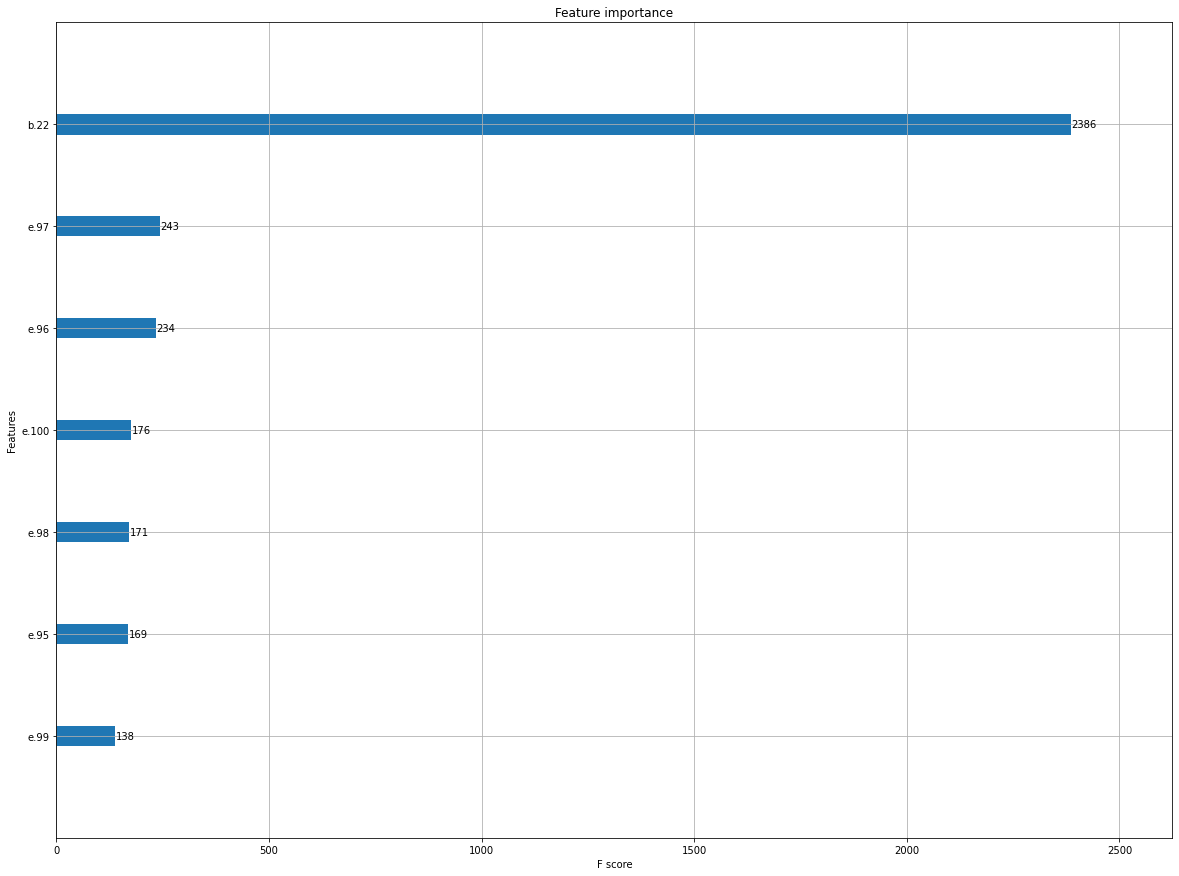

In [ ]:
df_train = df_spend[cols]
X = df_train.iloc[:,1:]
# print(X.head())
y = df_train.iloc[:,0]
# print(y.head())

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

model = XGBClassifier()
model.fit(X_train, y_train)

# feature importance
print(model.feature_importances_)

# plot
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(20, 15)
plt.show()

# Probabally can used 2nd round of feature selection 

In [ ]:
# KFold cross validation
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# Accuracy - simple
# y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy: 94.05% (3.36%)


[[4671   25    0    2    9    1]
 [ 252  811    0    1    0    0]
 [   5    6   83    0    0    0]
 [   0   27    0   36    0    0]
 [   7    0    0    0   39    0]
 [  34    5    0    5    0   47]]


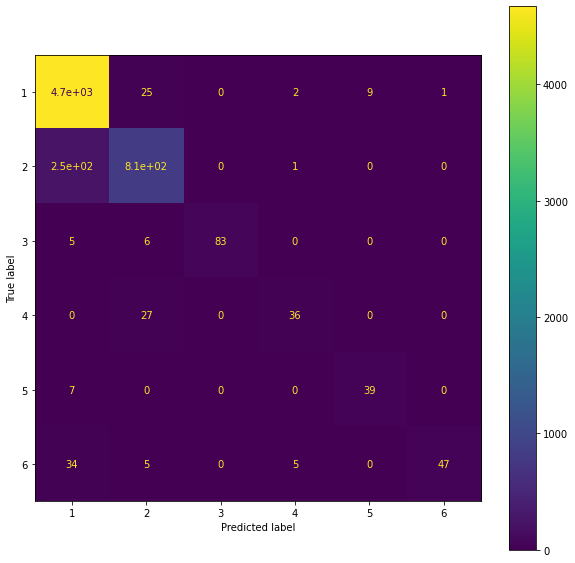

In [ ]:
from sklearn.metrics import plot_confusion_matrix

y_pred = model.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model,X_test, y_test, ax=ax)
plt.show()

In [ ]:
# Class Level Accuracy 
running = 0
for grp in confusion:
  total = 0
  true=grp[running]
  running = running + 1
  for value in grp:
    total += value
    # print(value)
  print('group:', running, 'true ', true, ' total', total, 'accuracy {:.2f}%'.format(true/total * 100))

group: 1 true  4671  total 4708 accuracy 99.21%
group: 2 true  811  total 1064 accuracy 76.22%
group: 3 true  83  total 94 accuracy 88.30%
group: 4 true  36  total 63 accuracy 57.14%
group: 5 true  39  total 46 accuracy 84.78%
group: 6 true  47  total 91 accuracy 51.65%


### Tunning (TODO)

In [ ]:
from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

folds = 3
param_comb = 5

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001 )

df_train = df_spend[cols]
X = df_train.iloc[:,1:]
# print(X.head())
y = df_train.iloc[:,0]
# print(y.head())

print(len(X), len(y))
# start_time = timer(None) # timing starts from this point for "start_time" variable
# random_search.fit(X, y) (Multiclass is not supported !!! TODO: Fix and change)
# timer(start_time)

### Prediction

In [ ]:
df_test = pd.read_csv('testdata.csv')
df_test.drop(['Unnamed: 0'],axis=1)
print(len(df_test.columns))
print(len(df_test))
df_test.head()

300
2150


,Unnamed: 0,month,var8,var6,a.1,a.2,a.3,a.4,var5,b.5,b.6,b.7,b.8,b.9,b.10,b.11,b.12,b.13,b.14,b.15,b.16,b.17,b.18,b.19,b.20,b.21,b.22,pov6,b.23,b.24,b.25,b.26,b.27,b.28,c.29,c.30,var7,c.31,c.32,c.33,...,c.245,c.246,c.247,c.248,c.249,c.250,c.251,c.252,c.253,c.254,c.255,c.256,c.257,c.258,c.259,c.260,c.261,c.262,c.263,c.264,c.265,c.266,c.267,c.268,c.269,c.270,c.271,c.272,c.273,c.274,c.275,c.276,c.277,c.278,c.279,c.280,c.281,c.282,c.283,f.284
0,9,1,1.0,NaN,1,11,1,47,8,2,1.0,1,1.0,1,211.0,0.0,1,211.0,NaN,12,12,12.0,12.0,10,0.0,0.0,31,NaN,14,0,0,0,0,0,2,2,2,NaN,2,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
1,15,1,2.0,NaN,1,11,1,65,27,1,NaN,1,1.0,2,NaN,NaN,2,NaN,NaN,4,4,4.0,4.0,5,0.0,0.0,14,NaN,0,0,0,0,0,0,1,1,1,1.0,1,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,16,1,2.0,NaN,1,6,1,65,27,2,1.0,1,1.0,2,NaN,NaN,2,NaN,NaN,56,56,56.0,56.0,12,0.0,0.0,45,NaN,0,0,0,0,0,0,2,2,3,NaN,2,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
3,24,1,1.0,NaN,1,3,1,3,2,1,NaN,1,1.0,1,35.0,3.0,1,90.0,NaN,5,5,5.0,5.0,6,0.0,0.0,14,NaN,0,0,0,0,0,0,2,2,2,NaN,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,32,1,1.0,NaN,1,5,1,83,3,1,NaN,1,4.0,1,94.0,5.0,1,200.0,4.0,4,4,4.0,4.0,5,0.0,0.0,14,NaN,0,0,0,0,0,0,2,2,2,NaN,2,0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN


In [ ]:
df_predict = df_test[cols]
print(len(df_predict.columns))
df_predict.head()

8


,pov6,e.96,e.97,e.95,e.100,e.99,e.98,b.22
0,NaN,2,2,2,2,2,2,31
1,NaN,3,2,3,2,2,2,14
2,NaN,4,4,4,4,4,4,45
3,NaN,2,2,2,2,2,3,14
4,NaN,2,1,2,1,1,1,14


In [ ]:
X = df_predict.iloc[:,1:]
y_pred = model.predict(X)
df_test.pov6 = y_pred
df_test.pov6.head()

0    1
1    1
2    2
3    1
4    1
Name: pov6, dtype: int64

In [ ]:
total_row = df_test.pov6.count()
print('Value 1 occurrence {:.2f}%'.format(df_test.pov6[df_test.pov6 == 1].count()/total_row * 100))
print('Value 2 occurrence {:.2f}%'.format(df_test.pov6[df_test.pov6 == 2].count()/total_row * 100))
print('Value 3 occurrence {:.2f}%'.format(df_test.pov6[df_test.pov6 == 3].count()/total_row * 100))
print('Value 4 occurrence {:.2f}%'.format(df_test.pov6[df_test.pov6 == 4].count()/total_row * 100))
print('Value 5 occurrence {:.2f}%'.format(df_test.pov6[df_test.pov6 == 5].count()/total_row * 100))
print('Value 6 occurrence {:.2f}%'.format(df_test.pov6[df_test.pov6 == 6].count()/total_row * 100))

Value 1 occurrence 81.72%
Value 2 occurrence 14.65%
Value 3 occurrence 1.77%
Value 4 occurrence 0.51%
Value 5 occurrence 1.07%
Value 6 occurrence 0.28%


### Download Prediction Result File 


In [ ]:
!rm -f testdata_result.csv
filename = 'testdata_result.csv'
df_test.to_csv(filename, index=False)
!head testdata_result.csv
from google.colab import files
files.download(filename) # Download

Unnamed: 0,month,var8,var6,a.1,a.2,a.3,a.4,var5,b.5,b.6,b.7,b.8,b.9,b.10,b.11,b.12,b.13,b.14,b.15,b.16,b.17,b.18,b.19,b.20,b.21,b.22,pov6,b.23,b.24,b.25,b.26,b.27,b.28,c.29,c.30,var7,c.31,c.32,c.33,c.34,c.35,c.36,c.37,c.38,c.39,c.40,c.41,c.42,c.43,c.44,c.45,c.46,c.47,c.48,c.49,c.50,c.51,c.52,c.53,c.54,c.55,c.56,c.57,c.58,c.59,c.60,c.61,c.62,b.63,c.64,c.65,c.66,c.67,c.68,c.69,c.70,c.71,c.72,c.73,c.74,c.75,c.76,c.77,c.78,c.79,c.80,c.81,c.82,c.83,c.84,c.85,c.86,c.87,c.88,c.89,c.90,c.91,c.92,c.93,d.94,e.95,e.96,e.97,e.98,e.99,e.100,e.101,f.102,f.103,f.104,f.105,f.106,f.107,f.108,f.109,f.110,f.111,f.112,f.113,f.114,f.115,f.116,f.117,f.118,f.119,f.120,f.121,f.122,f.123,a.124,var3,var4,c.125,c.126,c.127,pp.128,pp.129,pp.130,pp.131,pp.132,pp.133,pp.134,c.135,c.136,c.137,c.138,c.139,c.140,c.141,c.142,c.143,c.144,c.145,c.146,c.147,c.148,t7.149,t7.150,t7.151,t7.152,t7.153,t7.154,t7.155,t7.156,t7.157,t7.158,c.159,c.160,c.161,c.162,c.163,c.164,c.165,c.166,c.167,c.168,c.169,c.170,c.171,c.172,t7.173,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>